# Markowitz portfoilo optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxopt as opt
from cvxopt import blas, solvers
%matplotlib inline

In [2]:
n_assets = 4
n_obs = 1000

np.random.seed(123)
solvers.options['show_progress'] = False
return_vec = np.random.randn(n_assets, n_obs)
return_vec.shape

(4, 1000)

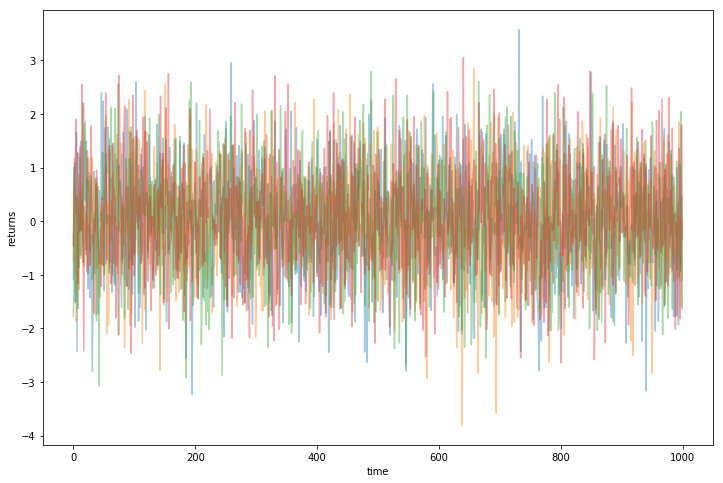

In [3]:
plt.figure(figsize=(12,8))
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [4]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights(n_assets))
print(rand_weights(n_assets))

[0.54066805 0.2360283  0.11660484 0.1066988 ]
[0.27638339 0.03006307 0.47850085 0.21505269]


In [5]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [6]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

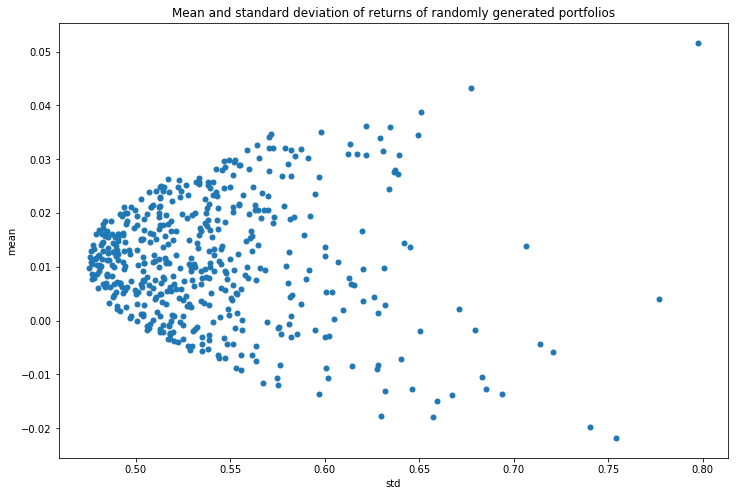

In [7]:
plt.figure(figsize=(12,8))
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

In [8]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrix
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    # Calcualte risk and returns
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

    # Calculate the 2-degree polynomial of the frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])

    # Calculate the optimal portfolio
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

## Markowitz - Efficient Frontier
- 투자 가능한 모든 개별자산이나 포트폴리오를 나타내는 투자 집합
- 위험 자산의 투자 조합은 항상 최소 분산 곡선 안에 존재
- 효율적 투자곡선 위에 존재하는 최적 위험 포트폴리오 조합을 찾아야 함 (Convex Optimization)

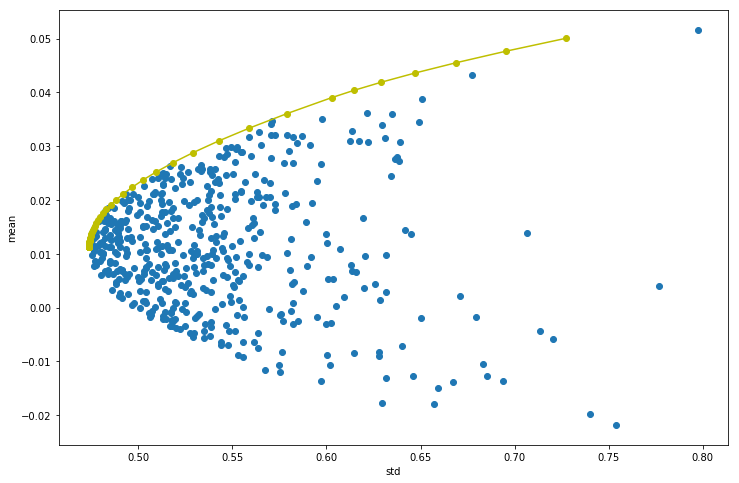

In [9]:
weights, returns, risks = optimal_portfolio(return_vec)

plt.figure(figsize=(12,8))
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [10]:
print(*weights, sep='\n')

[2.77880107e-09]
[3.20322848e-06]
[1.54301198e-06]
[0.99999525]


## Results
- Markowitz 모델의 한계점을 잘 보여주고 있음
- 소수의 우월한 자산으로 지나치게 치우칠 수 밖에 없음
- 금융 변수가 복잡해짐에 따라 종목간의 상관관계가 시간이나 환경에 따라 변화할 수 있음
- 자산의 수익이 정규분포를 따르지 않을 수도 있음
- 투자자는 이성적이고 위험회피적 vs 행동경제학파
- 이를 개선한 Black-Litterman 모델 (변동성의 비중을 활용하여 계산, 투자자의 의견 반영)
- Smart-Beta, Momentum, Etc.